# Incremento de frecuencia sin datos de pozos en tres dimensiones

* [Douglas Alberto Gómez Reyes](agomezr@imp.mx)- Dirección de Servicios en Exploración y Producción
* [Juan Delfino Lara Corona](jdlara@imp.mx)- Dirección de Servicios en Exploración y Producción
* [Liliana Vargas Meleza](lvargasm@imp.mx)- Dirección de Servicios en Exploración y Producción
* [Sergio Chávez Pérez](sergio.chavezp@gmail.com)- Dirección de Tecnología de Producto

<img src="logo_imp.png" alt="drawing" style="float:left;width:160px;height:100px;border:left;"/>

### Introducción

Para facilitar la interpretación sísmica y la caracterización geométrica de posibles zonas productoras de hidrocarburos se requieren imágenes sísmicas que representen fielmente el subsuelo, incluyendo detalles finos como capas delgadas. Sin embargo, a menudo los datos no cumplen las expectativas a pesar de haber sido cuidadosamente adquiridos y procesados. Experimentalmente, se observa que la tierra atenúa la señal sísmica de tal forma que la amplitud de las frecuencias altas se reduce más que en las frecuencias bajas, haciéndose más notorio a medida que la profundidad aumenta. Esta pérdida de información va de la mano con la disminución de resolución vertical, es decir, con la capacidad de distinguir la cima y base de una capa delgada, expresadas como reflexiones sísmicas. La resolución vertical, definida como la capacidad de distinguir dos reflexiones sísmicas antes de que pierdan su individualidad (Sheriff, 2002), es un tema fundamental en interpretación sísmica, cobrando mayor relevancia en zonas donde los objetivos geológicos son capas delgadas, con espesores menores que el límite de resolución. Se piensa, intuitivamente, que el incrementar el contenido de frecuencia representa una mejora en la resolución vertical.

Las técnicas de incremento de frecuencia han sido parte de la industria casi desde el origen del procesamiento de señales sísmicas (_e.g_ Liang _et al._, 2017). Una tendencia actual en la exploración de hidrocarburos consiste en adquirir datos sísmicos de banda ancha, con más contenido tanto en las altas como en las bajas frecuencias. Los avances tecnológicos en adquisición están enfocados, principalmente, en la eliminación de fantasmas, causantes de la degradación de la resolución vertical (Soubaras y Dowle, 2010; Reiser et al., 2012; Zhou et al., 2012). Además de los esfuerzos en adquisición, el procesamiento sísmico es fundamental para mejorar la resolución de las imágenes sísmicas. Técnicas como la deconvolución impulsiva (Robinson y Treitel, 2008) o el balanceo espectral (Yilmaz, 2001) se utilizan convencionalmente durante esta etapa, intentando mitigar el problema de atenuación de frecuencias y disminución de resolución vertical. A pesar de estos empeños, muchas veces resulta conveniente atacar el problema en la etapa de post-procesamiento debido al tiempo y costo que implica reprocesar los datos con distintos parámetros o volver a adquirirlos con tecnología de banda ancha. Tratando de satisfacer esta necesidad, la industria ha motivado el desarrollo de técnicas comerciales que post-procesan los datos con algoritmos que incrementan su contenido de frecuencia. Alternativamente, existen técnicas accesibles a través de consorcios académicos de investigación y otras que son relativamente fáciles y rápidas de implementar de manera libre.


Este hito genera flujos de trabajo y herramientas computaciones de incremento de frecuencia en datos sísmicos sin datos de pozo, sin depender de licencias comerciales de paquetería especializada. Para mostrar cumplir este hito, las herramientas computaciones se basan en las técnicas de un multiplicador de fase y filtrado orientado a estructuras con balanceo espectral. La primera técnica la implementamos en la paquetería libre de código abierto Madagascar y la segunda en AASPI. Madagascar es una paquetería que integra elementos de sus precursores SEPLib y Seismic Unix empleando esquemas de cómputo moderno. La paquetería consta de tres niveles: 

> 1) Programas de procesamiento: Más de 750 programas desarrollados principalmente en lenguaje C (también en C++, Fortran, Python, etc.) que actúan como filtros sobre los datos y pueden encadenarse mediante “pipes” de Unix o bien cuadernos de trabajo de Jupyter; 

> 2) Flujos de procesamiento SConstruct: Escritos en lenguaje de programación Python y ejecutados mediante el programa SCons;

> 3) Documentos reproducibles: conjunto de libros y artículos técnicos. AASPI es la paquetería de código abierto desarrollada por el consorcio académico de investigación Attribute-Assisted Seismic Processing and Interpretacion de la Universidad de Oklahoma, EEUU.

In [1]:
from m8r import view 
import math

### Lectura de datos sísmicos

Probamos los flujos de trabajo de las técnicas de incremento de frecuencia sin datos de pozos, en tres dimensiones, con datos sísmicos marinos, libres, propiedad del Departamento de Energía de Nueva Escocia y distribuido por la compañía [`dGB Earth Sciences`](https://dgbes.com/) bajo una licencia [CC BY-SA]() (Fig.1), y disponibles [aquí](https://opendtect.org/osr/pmwiki.php/Main/PENOBSCOT3DSABLEISLAND).

In [2]:
%%file carga.scons 

sis_ori = 'penobscot_ori500_3000.sgy'

Flow('seudo2d', sis_ori, 'segyread tfile=tfile.rsf bfile=bfile hfile=hfile verb=y endian=y')
Flow('cubo', 'seudo2d', '''intbin inv=n head=tfile.rsf xk=xline yk=iline | put label1=Tiempo 
                                             label3=inline label2=xline | window  min1=0.5 max1=3''')

Overwriting carga.scons


In [3]:
%%file display_input.scons

Plot('cubo-ori', 'cubo', '''byte gainpanel=all | grey3 frame1=550 frame2=100 frame3=100 
       title="Datos originales" flat=n point1=0.8 point2=0.8 point3=0 color=i''' )

Result('original', 'cubo-ori', 'SideBySideAniso' )

Overwriting display_input.scons


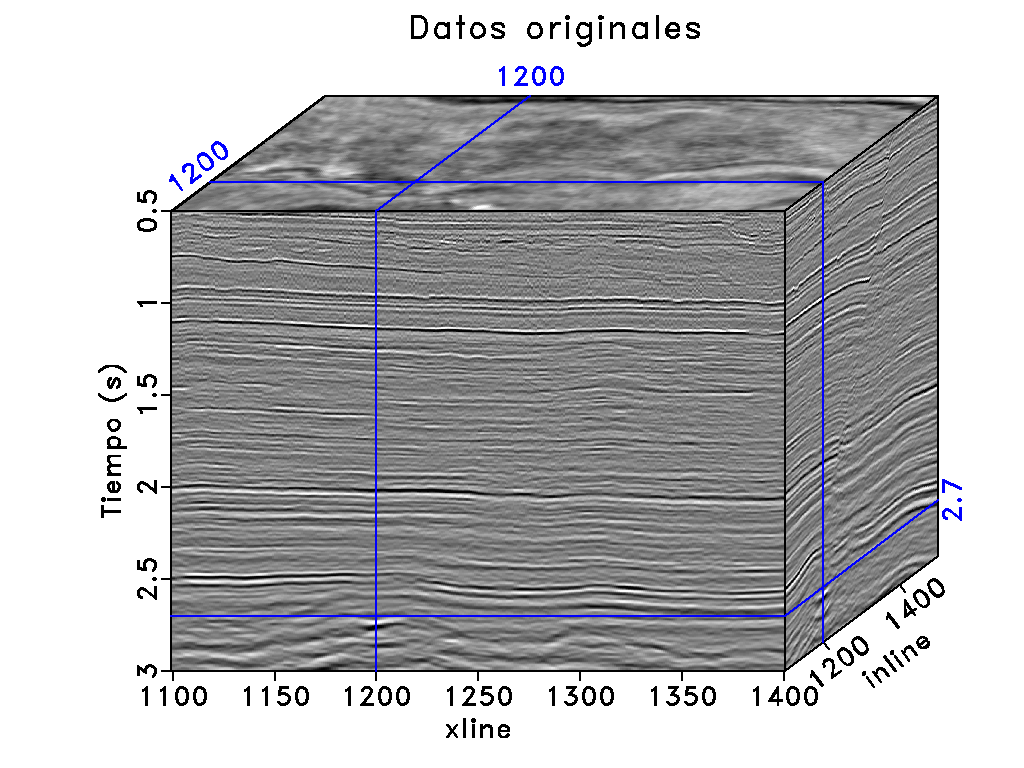

In [4]:
view('original')

<font size=2>**Figura 1.** Datos sísmicos originales, recortados en tiempo de 0.5 a 3.0 segundos.

## Derivadas orden superior

### Técnica I: Negativo de la segunda derivada y cuarta derivada

El negativo de la segunda derivada permite mejorar la definición de los datos sísmicos recorriendo el contenido de frecuencia hacia las frecuencias altas. En el dominio de las frecuencias, la derivada implica un cambio en la amplitudy frecuencia, proporcional a la amplitud y frecuencia originales, lo que produce un efecto de filtro pasa altas, recorriendo la frecuencia predominante hacia las frecuencias altas. La cuarta derivada recorre aún más las frecuencias hacia las altas frecuencias.

La Fig. 2 muestra el flujo de trabajo que implementamos en Madgascar.

<img src="derv1_wf.png" alt="drawing" style="float:left;width:480px;height:240px;border:left;"/>

<font size=2>**Figura 2.** Flujo de trabajo de derivadas de orden superior.

In [5]:
%%file der.scons 

Flow('der2', 'cubo', 'deriv | deriv | scale dscale=-1 ')
Flow('der4', 'cubo', 'deriv | deriv | deriv | deriv ')

Overwriting der.scons


In [6]:
%%file display_a.scons 

Plot('cubo-deriv2', 'der2', '''byte gainpanel=all | grey3 frame1=550 frame2=100 frame3=100 
           title="2da derivada" flat=n point1=0.8 point2=0.8 point3=0 color=i ''' )
Plot('cubo-deriv4', 'der4', ''' byte gainpanel=all | grey3 frame1=550 frame2=100 frame3=100 
           title="4ta derivada" flat=n point1=0.8 point2=0.8 point3=0 color=i ''' )
           
Result('derv', 'cubo-ori cubo-deriv2 cubo-deriv4', 'SideBySideAniso')

Overwriting display_a.scons


### Resultados 3D

La Fig. 3 muestra resultados de las pruebas en los datos sísmicos 3D.

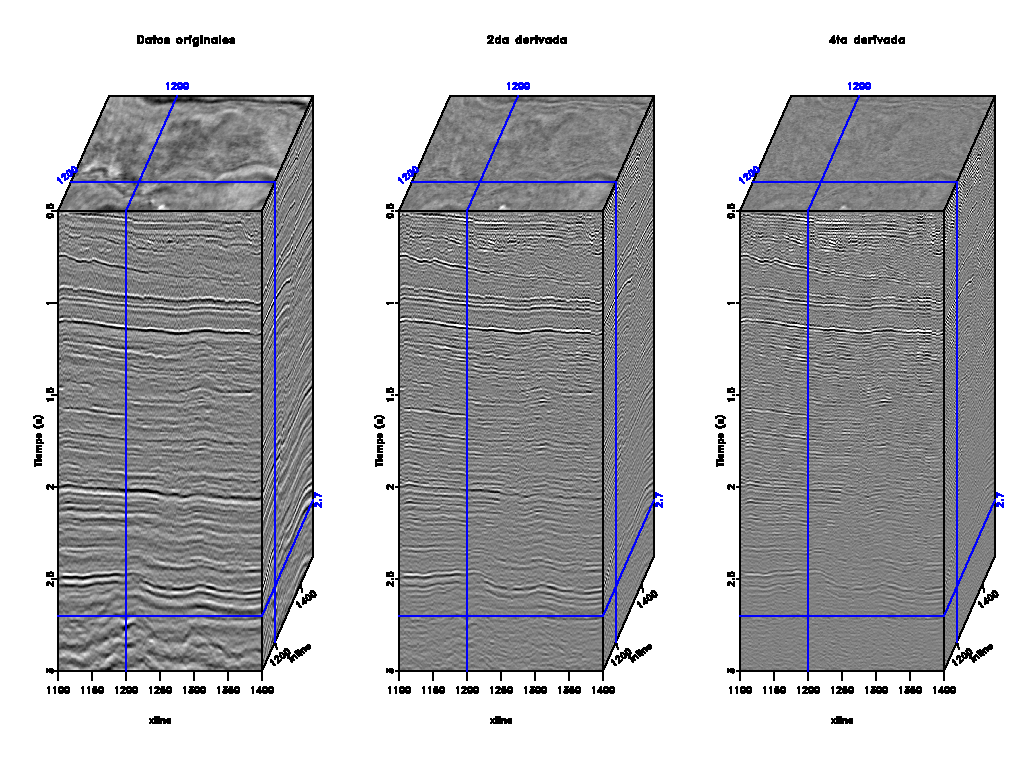

In [7]:
view('derv')

<font size=2>**Figura 3.** **Izquierda**. Datos sísmicos originales. **Centro** Negativo de la segunda derivada. **Derecha**. Cuarta derivada.

## Mutiplicador de fase

### Técnica II: Multiplicador de fase

Stark (2009) sugirió una estrategia para mejorar resolución vertical al incrementar el número de valles y cimas de trazas sísmicas incorporando un multiplicador N que acelere la fase instantánea. La Fig. 4 muestra el flujo que implementamos.

<img src="mult1_wf.png" alt="drawing" style="float:left;width:360px;height:250px;border:left;"/>

<font size=2>**Figura 4.** Flujo de trabajo del multiplicador de fase.

In [8]:
%%file mult.scons 

Flow('interp', 'cubo', 'sinc n1=1252 d1=0.002 o1=0.5')
Flow('cuad', 'interp', 'envelope hilb=y')
Flow('amp', None, 'math a=interp.rsf b=cuad.rsf output="sqrt(a^2 + b^2)"')
Flow('phase', None, 'math a=interp.rsf b=cuad.rsf output="atan(b/a)"')
Flow('mult2-inter', None, 'math a=amp.rsf b=phase.rsf output="a*cos(2*b)"')
Flow('mult3-inter', None, 'math a=amp.rsf b=phase.rsf output="a*cos(3*b)"')
Flow('sumn1n3-inter', None, 'math a=interp.rsf b=mult3-inter.rsf output="a+b"')
Flow('mult2', 'mult2-inter', 'sinc n1=626 d1=0.004 o1=0.5')
Flow('mult3', 'mult3-inter', 'sinc n1=626 d1=0.004 o1=0.5')
Flow('sumn1n3', 'sumn1n3-inter', 'sinc n1=626 d1=0.004 o1=0.5')

Overwriting mult.scons


In [9]:
%%file display_b.scons 

Plot('cubo-mult2', 'mult2', '''byte gainpanel=all | grey3 frame1=550 frame2=100 frame3=100 
               title="Multiplicador de fase N2" flat=n point1=0.8 point2=0.8 point3=0 color=i ''' )

Plot('cubo-mult3', 'mult3', '''byte gainpanel=all | grey3 frame1=550 frame2=100 frame3=100 
               title="e) Multiplicador de fase N3" flat=n point1=0.8 point2=0.8 point3=0 color=i ''' )

Plot('cubo-sumn1n3', 'sumn1n3', '''byte gainpanel=all | grey3 frame1=550 frame2=100 frame3=100 
               title="Multiplicador de fase N1+N3" flat=n point1=0.8 point2=0.8 point3=0 color=i ''' )

Result('mult', 'cubo-mult2 cubo-mult3 cubo-sumn1n3', 'SideBySideAniso' )

Result('derv_mult', 'cubo-ori cubo-deriv2 cubo-deriv4 cubo-mult2 cubo-mult3 cubo-sumn1n3', 'TwoRows' )

Overwriting display_b.scons


### Resultados 3D

La Fig. 5 muestra resultados de las pruebas en los datos sísmicos 3D.

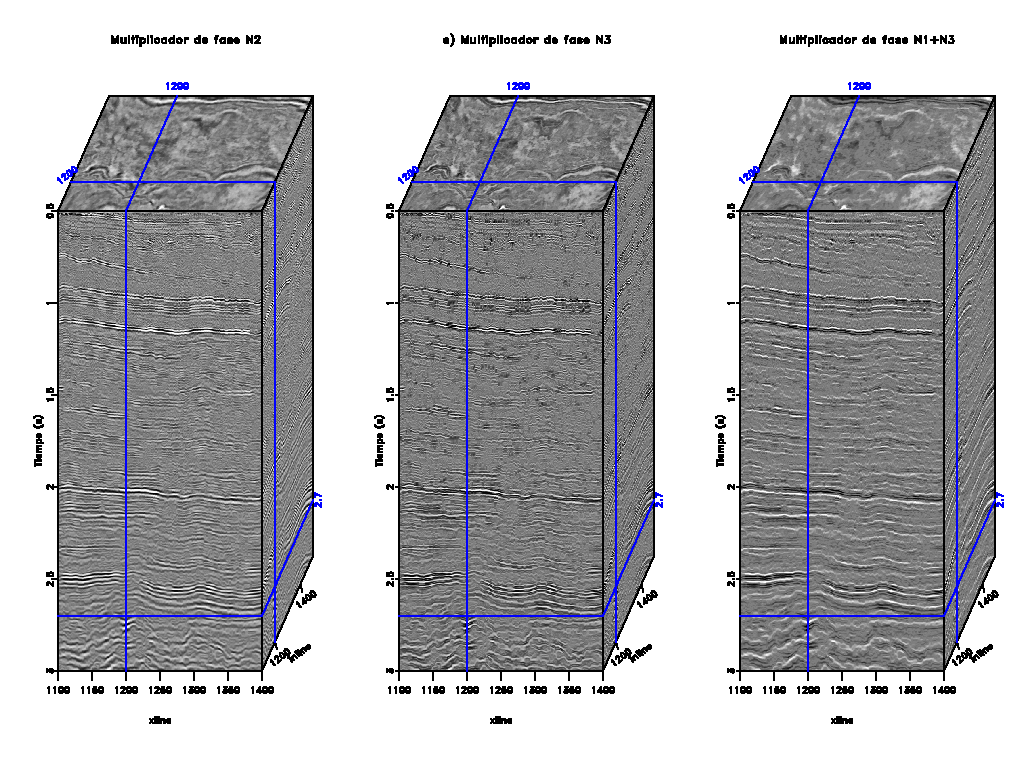

In [10]:
view('mult')

<font size=2>**Figura 5.**  **Izquierda**. Datos sísmicos originales. **Centro**. Multiplicador N3. **Derecha**. Multiplicador N1 + N3.

### Resultados en sección 

Las Fig. 6 y Fig. 7 muestran resultados de las pruebas de las derivadas de orden superior y multiplicador de fase en la línea longitudinal 1177.

In [11]:
%%file display_c.scons 

Flow('il1210-ori', 'cubo', 
                '''window min1=1.6 max1=2.6 max2=1300 min3=1177 n3=1''')
Flow('il1210-der2', 'der2', 
                '''window min1=1.6 max1=2.6 max2=1300 min3=1177 n3=1''')
Flow('il1210-der4', 'der4', 
                '''window min1=1.6 max1=2.6 max2=1300 min3=1177 n3=1''')
Flow('il1210_mult2', 'mult2', 
                '''window min1=1.6 max1=2.6 max2=1300 min3=1177 n3=1''')
Flow('il1210_mult3', 'mult3', 
                '''window min1=1.6 max1=2.6 max2=1300 min3=1177 n3=1''')
Flow('il1210_sumn1n3', 'sumn1n3', 
                '''window min1=1.6 max1=2.6 max2=1300 min3=1177 n3=1''')
##########
Plot('seis', 'il1210-ori',
                            'gaussmooth rect=3 | grey gainpanel=a  title="Datos Originales" color=g ')
Plot('der2', 'il1210-der2',
                            'gaussmooth rect=3 | grey gainpanel=a  title="2da derivada" color=g ')
Plot('der4', 'il1210-der4',
                            'gaussmooth rect=3 | grey gainpanel=a  title="4da derivada" color=g ')
##########                            
Plot('mult2', 'il1210_mult2',
                            'gaussmooth rect=3 | grey gainpanel=a  title="Multiplicador N2"  color=g')
Plot('mult3', 'il1210_mult3',
                            'gaussmooth rect=3 | grey gainpanel=a  title="Multiplicador N3"  color=g')
Plot('sumn1n3', 'il1210_sumn1n3',
                            'gaussmooth rect=3 | grey gainpanel=a  title="Multiplicador N1+N3" color=g')
##########

Result('seis2-der', 'seis der2 der4', 'SideBySideAniso')

Result('seis2-mult', 'seis mult2 sumn1n3', 'SideBySideAniso')

Overwriting display_c.scons


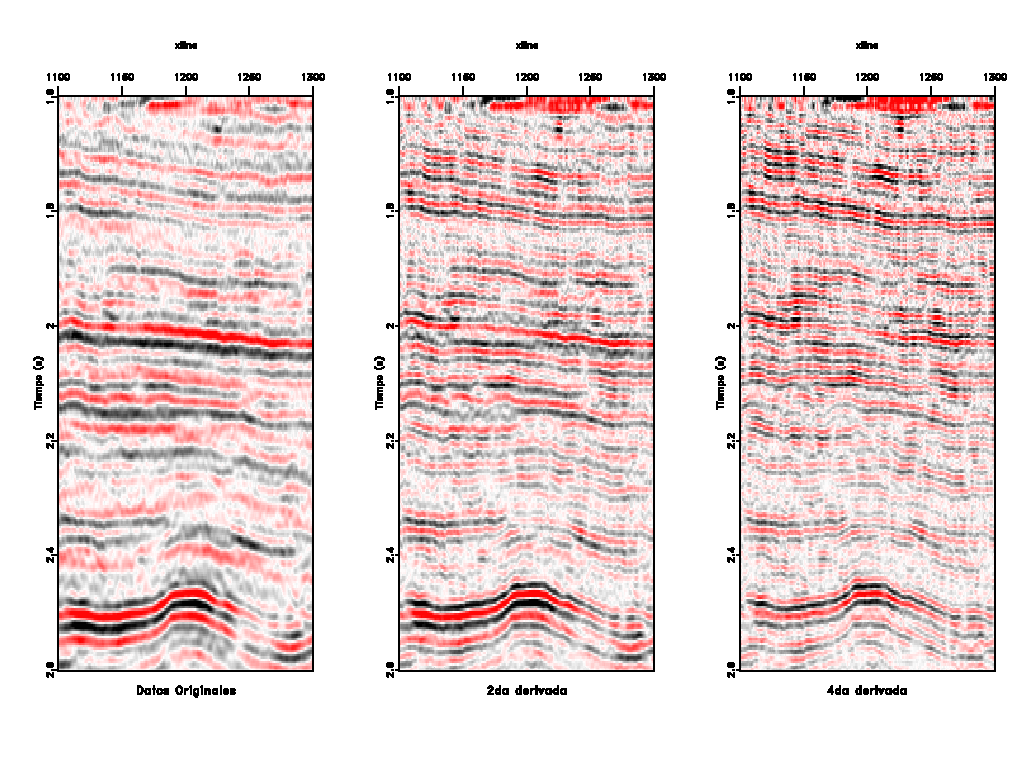

In [12]:
view('seis2-der')

<font size=2>**Figura 6.**  **Izquierda**. Datos sísmicos originales. **Centro**. Negativo de la segunda derivada. **Derecha**. Cuarta derivada.

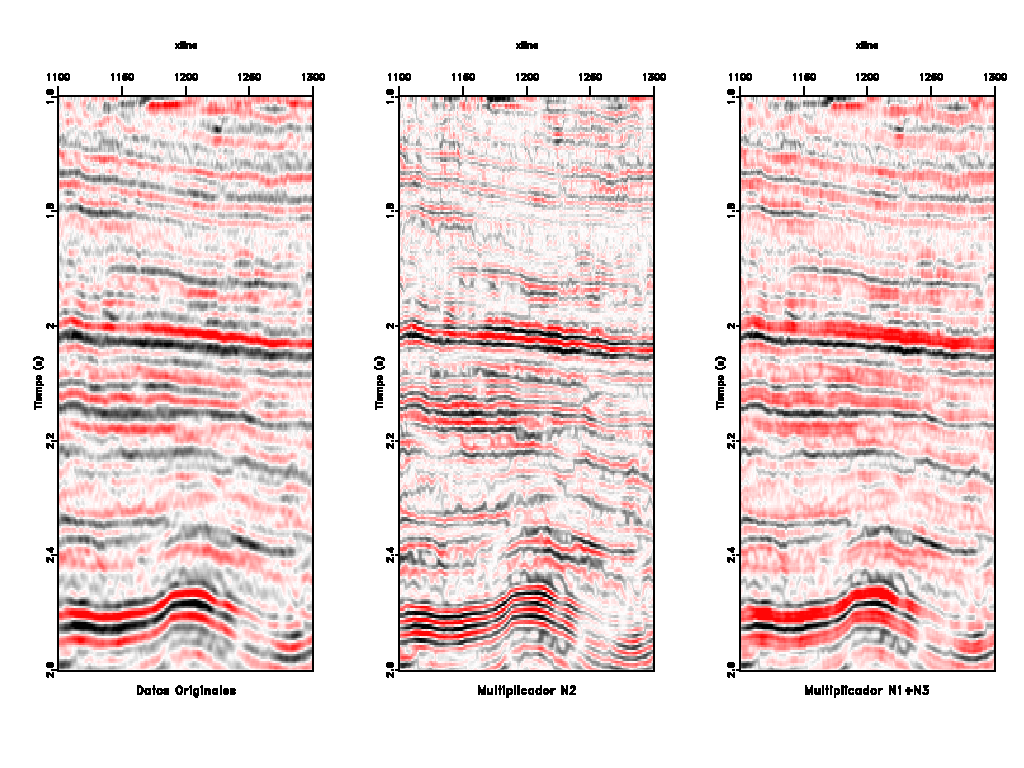

In [13]:
view('seis2-mult')

<font size=2>**Figura 7.**  **Izquierda**. Datos sísmicos originales. **Centro**. Multiplicador N2. **Derecha**. Multiplicador N1 + N3.

### Efecto del incremento de frecuencia

La Fig. 8 compara el efecto del incremento de frecuencia en los espectros de amplitud de cada una de las pruebas.

<img src="espec_pot_dermult1.png" alt="drawing" style="float:left;width:680px;height:260px;border:left;"/>

<font size=2>**Figura 8.**  **Izquierda**. Efecto en el espectro de amplitud al incrementar la frecuencia derivando.  **Derecha**. Efecto en el espectro de amplitud al incrementar la frecuencia multiplicando la fase.

La Fig. 9 muestra resultados de técnica I en la vecindad del pozo L-30. El recuadro de color amarillo muestra rasgos revelados por el operador derivada (2da y 4ta) y validados con el sismograma sintético.

<img src="derv2_wf.png" alt="drawing" style="float:left;width:920px;height:710px;border:left;"/>

<font size=2>**Figura 9.**  **Izquierda**. Datos sísmicos originales. **Centro**. Negativo de la segunda derivada. **Derecha**. Cuarta derivada. Los recuadros de color amarillo muestran eventos sísmicos resueltos que no eran distinguibles en los datos originales (recuadro de color blanco).

La Fig. 10 muestra resultados de la técnica II en la vecindad del pozo L-30. El recuadro de color amarillo muestra rasgos revelados por los multiplicadores de fase (N2 y N1 + N3) y validados con el sismograma sintético.

<img src="mult2_wf.png" alt="drawing" style="float:left;width:920px;height:710px;border:left;"/>

<font size=2>**Figura 10.**  **Izquierda**. Datos sísmicos originales. **Centro**. Multiplicador de fase N2. **Derecha**. Suma de multiplicadores N1 + N3. Los recuadros de color amarillo muestran eventos sísmicos resueltos que no eran distinguibles en los datos originales (recuadro de color blanco). Esta técnica, con respecto a la técnica I, ofrece mejorías inferiores de resolución vertical.

### Técnica III: Filtrado orientado a estructura (FOE) + balanceo espectral

Al aplicar filtrado orientado a estructura (FOE) en distintas bandas de frecuencia, junto con balanceo espectral, es posible aumentar la relación señal a ruido fuera de la banda central original y, al mismo tiempo, mejorar el contenido de frecuencia de los datos (Helmore, 2009). La Fig. 9 muestra el flujo de trabajo implementado.

<img src="foe_bal1.png" alt="drawing" style="float:left;width:380px;height:290px;border:left;"/>

Figura 9. Flujo de trabajo de FOE con balanceo espectral.
Las Figs. 10 y 11 muestran, respectivamente, resultados de pruebas en las líneas longitudinales 1177 y 1329. Las Figs. 12 y 13 muestran, respectivamente, resultados de la técnica III en la vecindad del pozo L-30 y B-41. El recuadro de color amarillo muestra rasgos revelados por FOE + balanceo espectral y validados con sismogramas sintéticos de los pozos en cuestión.

<img src="foe_bal2.png" alt="drawing" style="float:left;width:640px;height:640px;border:left;"/>

<img src="espec_pot_dermult2.png" alt="drawing" style="float:left;width:1180px;height:260px;border:left;"/>

In [14]:
#!scons -cQ